To run all these examples, you need to call the following packages:

In [25]:
using Kinbiont
using Plots
using Random
using Distributions
using Catalyst

To simulate data using Ordinary Differential Equations (ODEs), first, we declare the model and the parameters of the simulation:

In [59]:
model = "triple_piecewise_adjusted_logistic";
n_start = [0.1];
tstart = 0.0;
tmax = 500.0;
delta_t = 15.0;

param_of_ode = [0.06, 1.0, 200, 0.5, 0.001, 450, -0.0002];

Then we call the Kinbiont.jl API:

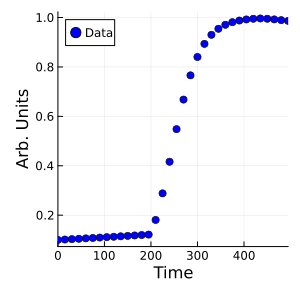

In [60]:
sim = Kinbiont.ODE_sim(model, n_start, tstart, tmax, delta_t, param_of_ode)

# Plotting scatterplot of data 
Plots.scatter(sim, xlabel="Time", ylabel="Arb. Units", label=["Data" nothing], color=:blue, size=(300, 300))

## Simulating Data with Stochastic Simulations

To simulate data using stochastic models:

In [61]:
sim_st = Kinbiont.stochastic_sim("Monod", # String of the model
   1, # Number of starting cells
   10000.1, # Starting number of molecules (in "biomass units") of the limiting nutrients
    0.0, # Start time of the simulation
    2000.0, # Final time of the simulation
    0.1, # Delta t for Poisson approximation
    11.1,
    10.1, # Monod constant
    0.06, # Maximum possible growth rate
   10.0, # Lag time
    0.000001, # Nutrient consumed per division (conc)
    1000.0 # Volume
);

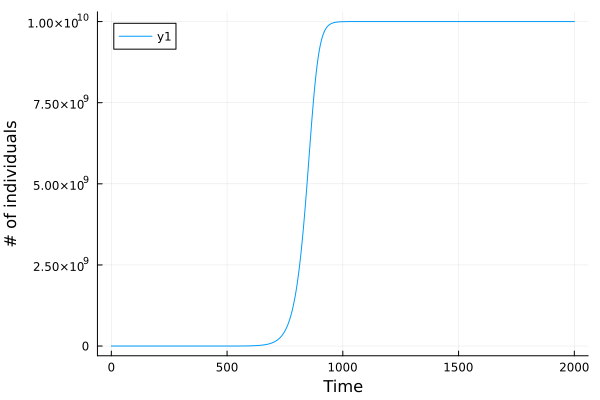

In [6]:
Plots.plot(sim_st[3], sim_st[1], xlabel="Time", ylabel="# of individuals")

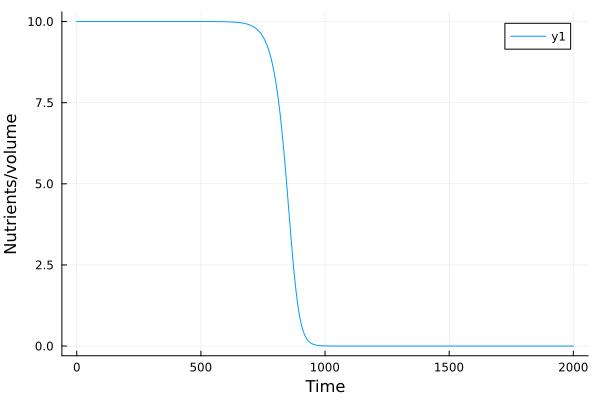

In [7]:
Plots.plot(sim_st[3], sim_st[2], xlabel="Time", ylabel="Nutrients/volume")

## Simulating ODEs System 

Generate Simulated Data with the SIR Model

In [62]:
Simulation = ODEs_system_sim(
    "SIR",          # Name of the model (Susceptible-Infected-Recovered)
    [0.9, 0.1, 0.0], # Initial conditions: [S, I, R]
    0.0,            # Start time of the simulation
    30.0,           # End time of the simulation
    1.0,            # Time step 
    [0.5, 0.3]      # Parameters of the ODE model: [Infection rate, Recovery rate]
)

retcode: Success
Interpolation: 1st order linear
t: 31-element Vector{Float64}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
  ⋮
 22.0
 23.0
 24.0
 25.0
 26.0
 27.0
 28.0
 29.0
 30.0
u: 31-element Vector{Vector{Float64}}:
 [0.9, 0.1, 0.0]
 [0.8529186918021906, 0.1148429839652941, 0.03223832423251542]
 [0.8024860170077062, 0.12870591669887158, 0.06880806629342225]
 [0.7501638019277552, 0.14057426107314472, 0.10926193699910014]
 [0.6975841284811191, 0.14955297094293726, 0.1528629005759437]
 [0.6463403036991948, 0.15501859443391822, 0.198641101866887]
 [0.5977874239011434, 0.15671637268484065, 0.24549620341401598]
 [0.5529225637070927, 0.15477204301661163, 0.2923053932762957]
 [0.5123472015084055, 0.14961613842962918, 0.33803666006196537]
 [0.4762937547834508, 0.14188923905441603, 0.38181700616213315]
 ⋮
 [0.287788980964616, 0.028107495097411957, 0.6841035239379719]
 [0.28407014315714907, 0.024023150293073666, 0.6919067065497772]
 [0.2809307929290034, 0.020495110075401037, 

We plot the results:

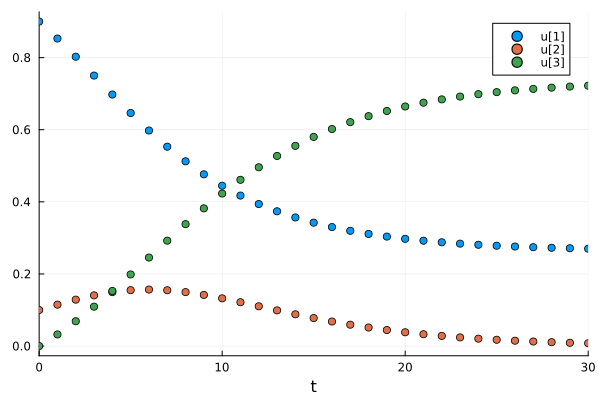

In [63]:
scatter(Simulation)  # Scatter plot of the simulation results

## Simulating ODEs System with Custom Model

Define the Enzyme Aggregation Model (ODE System) from: "Genome-Scale Reconstruction of Microbial Dynamic Phenotype: Successes and Challenges"

In [48]:
function enzyme_aggregation(du, u, param, t)
    # Unpacking state variables:
    e, x, y, m = u  
    # e  -> Free active enzymes
    # x  -> Enzyme-substrate complex
    # y  -> Aggregates (inactive enzyme forms)
    # m  -> Substrate concentration

    # Unpacking parameters:
    k1, k2, k3, k4, k_cat, n = param  
    # k1, k2 -> Aggregation/dissociation rates
    # k3, k4 -> Substrate binding/release rates
    # k_cat  -> Catalytic rate
    # n      -> Hill coefficient (cooperativity in aggregation)

    # ODE System:
    du[1] = k4 * x - k3 * m * e + k2 * y^n - k1 * e + k_cat * x  # Free enzyme balance
    du[2] = k3 * m * e - k4 * x - k_cat * x                      # Enzyme-substrate complex
    du[3] = k1 * e - k2 * y^n                                    # Inactive enzyme aggregates
    du[4] = -du[1]                                              # Substrate degradation rate
end

enzyme_aggregation (generic function with 1 method)

Define Initial Conditions and Parameters:

In [64]:
u0 = [1.0, 0.1, 0.1, 1.0]  # Initial conditions: [e, x, y, m]

param = [0.1, 0.1, 0.05, 0.05, 0.02, 2]  
# Parameter list: [k1, k2, k3, k4, k_cat, n]

6-element Vector{Float64}:
 0.1
 0.1
 0.05
 0.05
 0.02
 2.0

Run the Simulation:

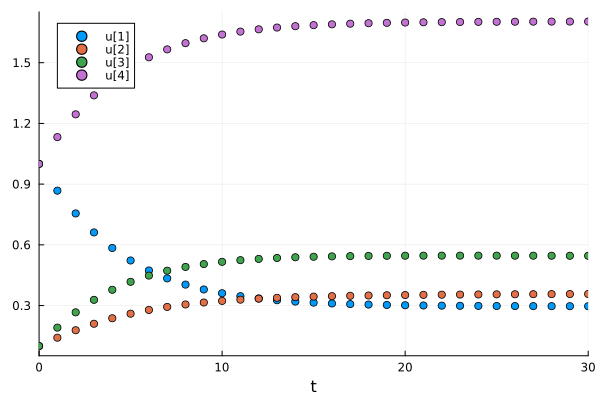

In [65]:
Simulation = ODEs_system_sim(
    enzyme_aggregation, # Custom ODE function
    u0,  # Initial conditions
    0.0, # Start time
    30.0, # End time
    1.0, # Time step for Poisson approximation
    param # Model parameters
)
scatter(Simulation)  # Scatter plot of the simulation results

## Simulating Reaction Network

The simulation of reaction networks employs https://docs.sciml.ai/Catalyst/stable/.  
The Michaelis-Menten model describes enzyme kinetics by modeling the interaction between a substrate and an enzyme to form a complex, which then converts into a product. The reaction follows three key steps:  
1. **Binding**: The substrate (S) binds to the enzyme (E) to form an enzyme-substrate complex (SE).  
2. **Dissociation**: The complex can either dissociate back into the substrate and enzyme or proceed to product formation.  
3. **Product Formation**: The enzyme-substrate complex converts into the product (P), releasing the enzyme.

This model is implemented using a reaction network approach in Kinbiont.

Define Initial Conditions:

In [66]:
u0 = [:S => 301, :E => 100, :SE => 0, :P => 0]
ps = [:kB => 0.00166, :kD => 0.0001, :kP => 0.1]

3-element Vector{Pair{Symbol, Float64}}:
 :kB => 0.00166
 :kD => 0.0001
 :kP => 0.1

Define the Michaelis-Menten Reaction Network:

In [67]:
model_Michaelis_Menten = @reaction_network begin
    kB, S + E --> SE
    kD, SE --> S + E
    kP, SE --> P + E
end 

Model ##ReactionSystem#260
States (4):
  S(t)
  E(t)
  SE(t)
  P(t)
Parameters (3):
  kB
  kD
  kP

Run the Simulation:

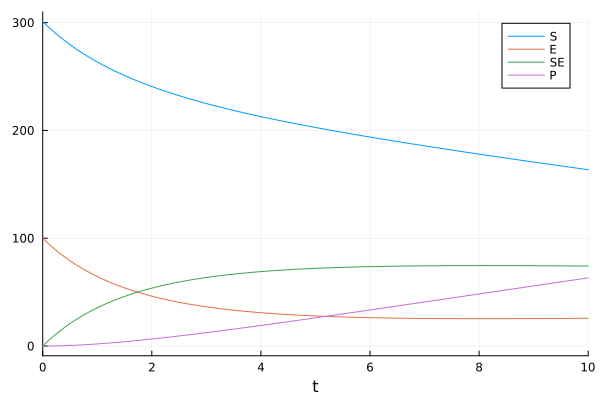

In [68]:
Simulation = Kinbiont.Kinbiont_Reaction_network_sim(
   model_Michaelis_Menten,
    u0,
    0.0, 10.0, 0.1, # Start time, end time, step size
    ps
)
plot(Simulation)

We can also consider other kinds of reactions for example.
Glycolysis is a metabolic pathway that converts glucose into pyruvate, generating ATP and NADH in the process. The pathway consists of multiple enzymatic reactions involving various intermediates. This model simulates the glycolysis pathway using a reaction network.

Define the Glycolysis Reaction Network:

In [69]:
model_Glycolysis = @reaction_network begin
    (kf1, kr1), Glucose + ATP <--> Glucose6P + ADP
    (kf2, kr2), Glucose6P <--> Fructose6P
    (kf3, kr3), Fructose6P + ATP <--> Fructose16BP + ADP
    (kf4, kr4), Fructose16BP <--> DHAP + GAP
    (kf5, kr5), DHAP <--> GAP
    (kf6, kr6), GAP + NADplus + Pi <--> BPG13 + NADH + Hplus
    (kf7, kr7), BPG13 + ADP <--> PG3 + ATP
    (kf8, kr8), PG3 <--> PG2
    (kf9, kr9), PG2 <--> PEP + H2O
    (kf10, kr10), PEP + ADP <--> Pyruvate + ATP
end

Model ##ReactionSystem#267
States (18):
  Glucose(t)
  ATP(t)
  Glucose6P(t)
  ADP(t)
⋮
Parameters (20):
  kf1
  kr1
  kf2
  kr2
⋮

Define Initial Conditions:

In [70]:
u0_glycolysis = [
    :Glucose => 100, :ATP => 200, :Glucose6P => 0, 
    :Fructose6P => 0, :Fructose16BP => 0, :DHAP => 0, 
    :GAP => 0, :NADplus => 100, :NADH => 0, :Pi => 100, 
    :BPG13 => 0, :PG3 => 0, :PG2 => 0, :PEP => 0, 
    :Pyruvate => 0, :ADP => 0, :H2O => 0, :Hplus => 0
];

Define Parameters:

In [71]:
ps_glycolysis = [
    :kf1 => 0.0011, :kr1 => 0.005, 
    :kf2 => 0.005, :kr2 => 0.002, 
    :kf3 => 0.02, :kr3 => 0.01, 
    :kf4 => 0.015, :kr4 => 0.007, 
    :kf5 => 0.01, :kr5 => 0.005, 
    :kf6 => 0.02, :kr6 => 0.01, 
    :kf7 => 0.03, :kr7 => 0.015, 
    :kf8 => 0.01, :kr8 => 0.005, 
    :kf9 => 0.008, :kr9 => 0.004, 
    :kf10 => 0.04, :kr10 => 0.02
];

Run the Simulation:

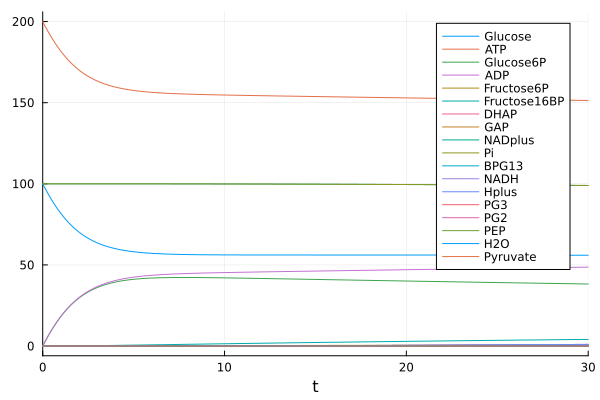

In [72]:
Simulation = Kinbiont.Kinbiont_Reaction_network_sim(
    model_Glycolysis,
    u0_glycolysis,
    0.0, 30.0, 0.1, 
    ps_glycolysis
)
plot(Simulation)

## Simulating Cybernetic Models in Kinbiont

Cybernetic models describe how microorganisms dynamically allocate resources to optimize growth and metabolism. These models include:
- Biomass and substrate dynamics
- Resource allocation strategies
- Enzyme synthesis and degradation rates

This tutorial demonstrates setting up and simulating a cybernetic model in Kinbiont.

First we need to define an allocation rule:

    
The `allocation_rule` in the cybernetic model defines how resources are allocated to different substrates, proteins, or other components of the system. You can create custom rules based on various factors such as substrate concentration, protein levels, or cost-benefit analysis. Below are some examples of custom allocation rules you can define:


In [73]:
  
# Function for proportional allocation based on substrate concentrations
function proportional_allocation_rule(a, b, V_S, k_S, Y_S, P, S, cost, protein_thresholds)
# Normalize substrate concentrations to create allocation vector
alloc = S ./ sum(S)
return alloc
end
function threshold_switching_rule(a, b, V_S, k_S, Y_S, P, S, cost, protein_thresholds)
    n = length(S)
    alloc = zeros(n)
    # Sort substrates by descending utilization rate (V_S)
    sorted_indices = sortperm(V_S, rev=true)

    for i in sorted_indices
        if S[i] > protein_thresholds
            alloc[i] = 1.0    # Allocate all resources to this substrate
            break
        end
    end

    # If no substrate is above the threshold, fallback to equal allocation
    if sum(alloc) == 0
        alloc .= 1.0 / n
    end

    return alloc
end

function cost_benefit_allocation_rule(a, b, V_S, k_S, Y_S, P, S, cost, protein_thresholds)
    # Calculate benefit-to-cost ratio
    benefits = V_S ./ cost
    # Normalize the allocation vector to sum to 1
    alloc = benefits ./ sum(benefits)
    return alloc
end

function feedback_controlled_allocation_rule(a, b, V_S, k_S, Y_S, P, S, cost, protein_thresholds)
    n = length(S)
    alloc = ones(n)

    for i in 1:n
        if P[i] > protein_thresholds[i]
            alloc[i] = 0.0  # Stop allocating to this substrate if protein exceeds threshold
        end
    end

    # Normalize the allocation vector to sum to 1
    alloc = alloc ./ sum(alloc)
    return alloc
end

feedback_controlled_allocation_rule (generic function with 1 method)

We can then declare the Cybernetic model:

In [74]:
# We import the Kinbiont_Cybernetic_Model class from the Kinbiont module
import Kinbiont.Kinbiont_Cybernetic_Model

model = Kinbiont_Cybernetic_Model(
    Bio_mass_conc = 1.0,  # Initial biomass concentration
    Substrate_concentrations = [3.0, 3.0],  # Concentrations of 2 substrates
    Protein_concentrations = [0.0, 0.0],  # Initial protein concentrations
    allocation_rule = threshold_switching_rule,  # Dynamic resource allocation rule
    reaction = nothing,  # No specific reaction function provided
    cost = nothing,  # No cost function
    protein_thresholds = 0.01,  # Protein activation threshold
    a = [0.1, 0.4],  # Synthesis rate constants for proteins
    b = [0.00001, 0.000001],  # Degradation constants for proteins
    V_S = [0.7, 0.1],  # Substrate utilization rates
    k_S = [0.1, 0.11],  # Saturation constants for substrates
    Y_S = [0.07, 0.11]  # Yield coefficients for biomass per substrate
)

Kinbiont_Cybernetic_Model(1.0, [3.0, 3.0], [0.0, 0.0], threshold_switching_rule, nothing, Union{Nothing, Float64}[0.1, 0.4], Union{Nothing, Float64}[1.0e-5, 1.0e-6], Union{Nothing, Float64}[0.7, 0.1], Union{Nothing, Float64}[0.1, 0.11], Union{Nothing, Float64}[0.07, 0.11], nothing, 0.01)

After the model is defined you can run the simulation with

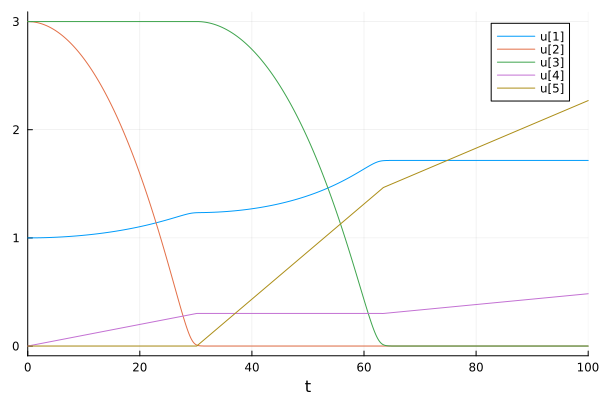

In [75]:
simulation = Kinbiont_Cybernetic_Model_simulation(model, 0.0, 100.0, 0.1)

plot(simulation)

## Data Preprocessing

Any curve can be processed with a calibration curve or with smoothing.

We start by applying a rolling average smoothing to the data. In the example, a rolling window of size 7 is applied to the original data (`data_OD` generated in the previous examples). 

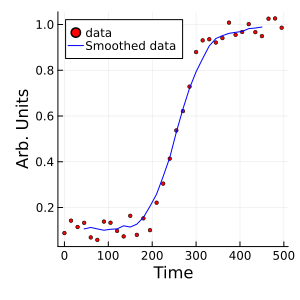

In [42]:
model = "triple_piecewise_adjusted_logistic"
n_start = [0.1]
tstart = 0.0
tmax = 500.0
delta_t = 15.0

param_of_ode = [0.06, 1.0, 200, 0.5, 0.001, 450, -0.0002] 
#adding uniform random noise
noise_unifom = rand(Uniform(-0.05,0.05),length(sim.t))
sim = Kinbiont.ODE_sim(model, n_start, tstart, tmax, delta_t, param_of_ode)


data_t = reduce(hcat,sim.t)
data_o = reduce(hcat,sim.u)
data_OD = vcat(data_t,data_o)
data_OD[2,:] = data_OD[2,:] .+ noise_unifom
Plots.scatter(data_OD[1, :], data_OD[2, :], xlabel="Time", ylabel="Arb. Units", label=[ "data " nothing], markersize=2, color=:RED, size=(300, 300))
data_ODsmooth = Kinbiont.smoothing_data(data_OD)
data_ODsmooth = Matrix(data_ODsmooth)

# Plotting scatterplot of smoothed data
Plots.plot!(data_ODsmooth[1, :], data_ODsmooth[2, :], xlabel="Time", ylabel="Arb. Units", label=["Smoothed data " nothing], markersize=2, color=:blue, size=(300, 300))

Furthermore, to address potential external influences, a correction for multiple scattering is applied to the smoothed data. This correction is executed through the `correction_OD_multiple_scattering` function, requiring an external file (`calibration_curve.csv`). An example of such a file is given in the GitHub repository.

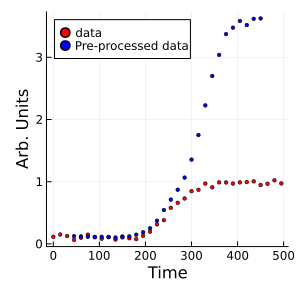

In [39]:
data_ODsmooth = Kinbiont.correction_OD_multiple_scattering(data_ODsmooth, "your_path/data_examples/cal_curve_example.csv")
Plots.scatter(data_OD[1, :], data_OD[2, :], xlabel="Time", ylabel="Arb. Units", label=[ "data " nothing], markersize=2, color=:RED, size=(300, 300))

# Plotting scatterplot of preprocessed data
Plots.scatter!(data_ODsmooth[1, :], data_ODsmooth[2, :], xlabel="Time", ylabel="Arb. Units", label=["Pre-processed data" nothing], markersize=2, color=:blue, size=(300, 300))
